# Example: Dynamic Delta Neutral Hedging to Compensate for Price Fluctuations
[Delta hedging](https://en.wikipedia.org/wiki/Delta_neutral) is a strategy used in options trading to minimize the risk associated with price movements in the underlying asset. This approach involves using other options contracts or shares of the underlying asset to achieve a delta-neutral position, i.e., eliminating the position's directional bias.
* __Scenario__: You are long, i.e., you purchased a `TSLA` put option (thus, you are short the shares) and are concerned about how the price movement of `TSLA` shares influences the overall risk of your options position. Toward this risk, let's explore constructing a delta-neutral hedge.

From the buyer's perspective, by purchasing a put option, the buyer believes that `TSLA` shares will decline in price, i.e., the buyer is `bearish` on `TSLA.` Let's explore how delta-neutral hedging would work for a long put.

## Learning objectives
Fill me in.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed StaticArrays ───── v1.9.6
   Installed MathOptInterface ─ v1.31.0
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`

## Prerequisites
Before we set up the [delta-neutral hedge](https://www.investopedia.com/terms/d/deltahedging.asp) on the `TSLA` put option, let's first define some constants we'll use later. This includes details about the contract and parameters controlling the simulation. After that, we'll proceed to load data for `TSLA` put contracts to explore. Lastly, we'll load price and volatility data for TSLA, which we'll use to build a share price and volatility projection. Please review this section before moving on to the tasks below, and make sure you understand the various variables and datasets loaded here, as they will be important later on.

### Constants
- First, we need to set up details regarding the options contracts we are exploring. The variable `DTE::Float64` represents the days to the expiration of the options contracts (measured in days), `Δt::Float64` represents the time step used in the simulations. In this case, we are using 1-minute aggregate data (measured in years). The variable `number_of_trading_periods::Int64` represents the number of trading periods we explore, i.e., the number of minutes that we want to simulate, and `T::Float64` denotes the length of the options contracts (measured in years).
- Next, we define information about `TSLA` and the parameters for the binomial lattice used in the simulation. The variable `β::Float64` represents the beta value for `TSLA`, `h::Int64` represents the number of levels of the pricing tree, the variable `risk_free_rate::Float64` represents the risk-free rate (in this case assumed to be the yield on a 10-year US Treasury Note), the variable `number_of_samples::Int64` specifies the number of samples (alternative futures) we will generate in the simulation, and finally, `sample_synthetic_index::Int64` is a randomly chosen index which specifies which sample we'll use in the simulation.

In [6]:
DTE = 60.5; # data from mid-day, add a little something something so we recover the midpoint premium (ish) (all parameters fixed)
Δt = (1/390)*(1/252); # 1-min trading periods
number_of_trading_periods = 60; # How many trading periods will we simulate?
T = (DTE)*(1/365); # Duration of trading periods in option years
β = 2.32; # TSLA 5y monthly beta value 06-25-24
h = 366; # 6-points per trading period
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
number_of_samples = 1000; # number of samples to generate
sample_synthetic_index = rand(1:number_of_samples); # generate random synthetic index to explore (must be <= number_of_samples)

### Contracts
In this example, we'll use data for `TSLA` contracts from approximately 60 days to expiration. First, we load the data stored as a file in the [HDF5 data format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#:~:text=HDF5%20simplifies%20the%20file%20structure,hold%20datasets%20and%20other%20group), using the [load method from the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). The [load function](https://juliaio.github.io/JLD2.jl/dev/#save-and-load-functions) returns a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) holding the contract data in the `data` key (we can access by passing the key to the dictionary instance). We store the contract information in the `all_options_dataset::Vector{Dict{String, Any}}` variable, a vector of dictionaries holding information for put and call contracts:

In [8]:
all_options_dataset = load(joinpath(_PATH_TO_DATA, "TSLA-today-2023-06-19-exp-2023-08-18-dte-60d.jld2")) |> dict -> dict["data"];

Since we are interested in only put contracts, let's filter out the call contracts and build a `put_contract_dataset::Vector{Dict{String, Any}}` data structure holding the put contract information using a `for-loop.`
* First, we initialize storage to hold the put contracts in the `put_contract_dataset::Array{Dict{String, Any},1}` array. Next, we iterate through each contract in the `all_options_dataset` using the [Julia eachindex iteration pattern](https://docs.julialang.org/en/v1/base/arrays/#Base.eachindex). On `Line 3`, we access contract `i` from the `all_options_dataset` (stored as the `contract` variable). Then, on `Line 4`, we check if `contract` is a call or put. If `contract` is a put, we store it in the `put_contract_dataset` using the [Julia `push!()` method for adding items to an array](https://docs.julialang.org/en/v1/base/collections/#Base.push!).
* We've added some additional logic (encoded as a second clause using the [Julia `&&` short-circuit operator which encodes the logical AND operation](https://docs.julialang.org/en/v1/manual/control-flow/#Short-Circuit-Evaluation)) to the `if` statement on `Line 4.` The second clause checks the contract strike price, and removes contracts that are outside of a strike price range, i.e., we want contracts with strikes
$K\in\left[K_{\text{min}},\,K_{\text{max}}\right]$ where you specify the minimum strike $K_{\text{min}}$ and the maximum strike $K_{\text{max}}$.

In [10]:
put_contract_dataset = Array{Dict{String,Any},1}();
for i ∈ eachindex(all_options_dataset)
    contract = all_options_dataset[i];
    if (contract["details"]["contract_type"] == "put" && 
            (200 ≤ contract["details"]["strike_price"] && contract["details"]["strike_price"] ≤ 300)) # filter on strike price
        push!(put_contract_dataset, contract) # store put contract
    end
end

#### Choose a contract instance
There are many put options contracts to choose from, and you can choose whichever contract instance you want, but we'll explore a put that is close to the money, i.e., $K\sim{S}_{o}$ (the strike is close to the current share price). We choose the contract at `index = 9` and store the contract data in the `example_put_contract::Dict{String, Any}` variable.

In [12]:
example_put_contract = put_contract_dataset[9]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>25.03, "change…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>23.7, "ask"=>23.8, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.198501, "gamma"=>0.0063…
  "open_interest"      => 2878
  "implied_volatility" => 0.605621
  "break_even_price"   => 236.3

Finally, we set some data from this contract, in particular, the initial share price in the `Sₒ::Float64` variable and the implied volatility `IVₒ::Float64` variable:

In [14]:
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE

### Share price and volatility data

One-minute aggregate data for `TSLA` and `VIX` for 2023

In [17]:
underlying_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "TSLA-OHLC-1-min-aggregate-2023.csv"), DataFrame);
volatility_data_df = CSV.read(joinpath(_PATH_TO_DATA, "VIX-OHLC-1-min-aggregate-2023.csv"), DataFrame);

Compute the vwap, and the log_growth_matrix 

In [19]:
growth_rate_array = vwap(underlying_price_data_df) |> data -> log_growth_matrix(data, Δt = Δt);

Compute (u,d,p) parameters from data assuming a real-world probability measure

In [21]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(growth_rate_array; Δt = Δt);

## Task 1: Construct and Sample Synthetic Future Market State Trajectories
Fill me in.

### TODO: Sample Discrete Binomial Equity Tree of Future Share Prices

In [24]:
price_tree_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = number_of_trading_periods));

Fill me in

In [26]:
samples_share_price = VLQuantitativeFinancePackage.sample(price_tree_model, number_of_trading_periods, 
    number_of_paths = number_of_samples);

`Unhide` the code block below to see how we plotted the `TSLA` volume weighted average price for your choice of the `sample_plot_index` variable:

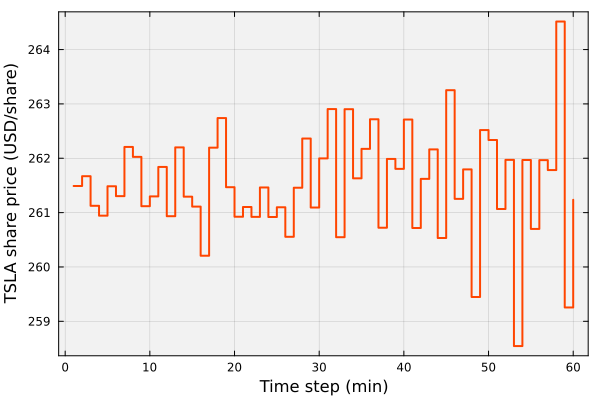

In [28]:
let
    plot(samples_share_price[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:orangered1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

### TODO: Sample Synthetic Future Implied Volatility Trajectory
Fill me in

In [30]:
vol_of_vol = log_growth_matrix(volatility_data_df, Δt = 1.0, keycol=:close) |> x-> std(x) |> x-> β*x # keep on 1 min scale

0.007186796052074137

In [31]:
samples_IV = Normal(IVₒ,vol_of_vol) |> d -> rand(d, number_of_trading_periods, number_of_samples)
samples_IV[1,1:end] .= IVₒ;

`Unhide` the code block below to view how we generated a plot of the implied volatility for a put option with a strike price of `K = 210 USD per share` on `TSLA` with `DTE = 60 days` until expiration, where the initial share price is `Sₒ = 261.49 USD per share`. This is for your chosen value of the `sample_plot_index` variable:

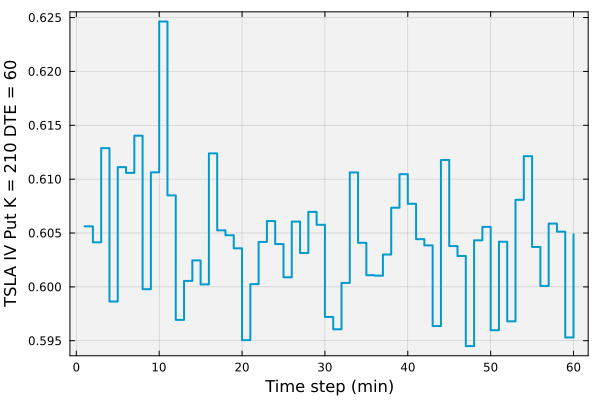

In [33]:
let
    plot(samples_IV[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:deepskyblue3, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA IV Put K = 210 DTE = 60", fontsize=18)
end

## Task 2: Construct a dynamic delta-neutral hedged position on TSLA
Fill me in

In [35]:
put_option_model = build(MyAmericanPutContractModel, (
    K = example_put_contract["details"]["strike_price"], 
    premium = example_put_contract["last_quote"]["midpoint"], # use last quote midpoint price
    DTE = T,
    sense = 1,
    copy = 1,
    IV = IVₒ
));

Compute Greeks

In [37]:
long_greek_dictionary = Dict{Union{MyAmericanPutContractModel,MyAmericanCallContractModel}, NamedTuple}();

In [38]:
long_greek_dictionary[put_option_model] = (
    delta_value = delta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    theta_value = theta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    vega_value = vega(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    gamma_value = gamma(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate));

### Check: Check $\Delta_{p}$ calculation for TSLA option

In [40]:
(long_greek_dictionary[put_option_model].delta_value - example_put_contract["greeks"]["delta"])/(example_put_contract["greeks"]["delta"])

-0.03000039585937055

### TODO: Simulate Dynamic Hedge Assuming Perfect Information 
Explain code below.

In [42]:
perfect_hedge_simulation = Dict{Int64,NamedTuple}();
nₒ, Pₒ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium;
for i ∈ 1:number_of_trading_periods

    Tᵢ = put_option_model.DTE - (i-1)*Δt;
    Sᵢ = samples_share_price[i, sample_synthetic_index]; # note: i = 1 is the *current* time point
    IVᵢ = samples_IV[i, sample_synthetic_index];

    # compute the premium using CRR -
    Pᵢ = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = risk_free_rate, T = Tᵢ, σ = IVᵢ)) |> (x-> populate(x, Sₒ = Sᵢ, h = h)) |> mᵢ -> premium(put_option_model, mᵢ)   
    
    # compute the delta hedge (number of shares I need to be long)
    nᵢ = nₒ*(Sₒ/Sᵢ) - 100*(Pᵢ - Pₒ)/Sᵢ;
    Z = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ)
    LS = (nᵢ*Sᵢ - nₒ*Sₒ)
    DP = 100*(Pᵢ - Pₒ)
    
    # data capture -
    perfect_hedge_simulation[i-1] = (shares = nₒ, shares_next = nᵢ, price = Sₒ, price_next = Sᵢ, IV = IVᵢ, premium = Pₒ, 
        premium_next = Pᵢ, hedge = Z, long_shares_diff = LS, long_premium_diff = DP)

    # update -
    nₒ = nᵢ;
    Pₒ = Pᵢ;
    Sₒ = Sᵢ;
end

### Visualize perfect counter-share trajectory
Fill me in

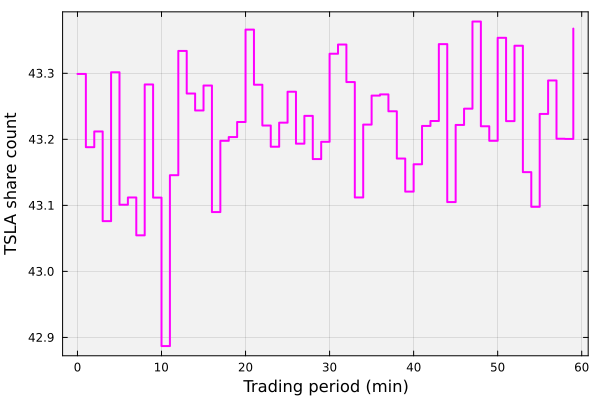

In [44]:
let
    local_data_array = Array{Float64,2}(undef, number_of_trading_periods, 2);
    for i ∈ 0:(number_of_trading_periods - 1)
        local_data_array[i+1,1] = i;
        local_data_array[i+1,2] = perfect_hedge_simulation[i].shares;
    end
    plot(local_data_array[:,1], local_data_array[:,2], linetype=:steppost, label="", lw=2, c=:magenta1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period (min)", fontsize=18)
    ylabel!("TSLA share count", fontsize=18)
end

## Task 3: Build profit, loss, and cost table for a dynamic delta-neutral hedged position in TSLA
What am I trying to do??

In [46]:
let
 
    tmp = DataFrame();
    tmp_cost_sum = Array{Float64,1}();
    for i ∈ 1:number_of_trading_periods-1

        data_tuple = perfect_hedge_simulation[i-1];
    
        # current -
        nₒ = data_tuple.shares;
        Sₒ = data_tuple.price;
        Pₒ = data_tuple.premium;
    
        # next -
        nᵢ = data_tuple.shares_next;
        Sᵢ = data_tuple.price_next;
        Pᵢ = data_tuple.premium_next;
    
        # compute H -
        H = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ);
        
        # What is the cost of maintaining the hedge?
        dnᵢ = (nᵢ - nₒ);
        Cᵢ = -sign(dnᵢ)*abs(dnᵢ)*Sᵢ
        push!(tmp_cost_sum,Cᵢ);

        # package -
        row_df = (
            i = (i - 1),
            nᵢ = nₒ,
            Sᵢ = Sₒ,
            Pᵢ = Pₒ,
            nᵢ₊₁ = nᵢ,
            Sᵢ₊₁ = Sᵢ,
            Pᵢ₊₁ = Pᵢ,
            H = H,
            C = Cᵢ,
            ΣC = sum(tmp_cost_sum)
        );
        push!(tmp, row_df)
    end
    pretty_table(tmp[1:20,:])
end

┌───────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬──────────────┬──────────┬───────────┐
│     i │      nᵢ │      Sᵢ │      Pᵢ │    nᵢ₊₁ │    Sᵢ₊₁ │    Pᵢ₊₁ │            H │        C │        ΣC │
│ Int64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │      Float64 │  Float64 │   Float64 │
├───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼──────────────┼──────────┼───────────┤
│     0 │  43.299 │  261.49 │    23.7 │ 43.1881 │  261.49 │   23.99 │  1.73372e-12 │     29.0 │      29.0 │
│     1 │ 43.1881 │  261.49 │   23.99 │ 43.2119 │  261.67 │   23.85 │  2.98428e-13 │ -6.22809 │   22.7719 │
│     2 │ 43.2119 │  261.67 │   23.85 │  43.076 │ 261.125 │   24.44 │ -1.42109e-14 │  35.4738 │   58.2457 │
│     3 │  43.076 │ 261.125 │   24.44 │ 43.3015 │ 260.943 │   23.93 │ -1.56319e-13 │  -58.842 │ -0.596307 │
│     4 │ 43.3015 │ 260.943 │   23.93 │ 43.1009 │ 261.485 │   24.22 │ -8.52651e-14 │  52.4514 │   51.8551 │
│     5 │ 43.1009 │ 261.485 

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.